<a href="https://colab.research.google.com/github/darshank528/Project-STORM/blob/master/rs_Bottleneck.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import MultiStepLR
from torch.optim.optimizer import Optimizer
from torchsummary import summary

#setting device configuration
device=torch.device("cuda" if torch.cuda.is_available else "cpu")

def build_model(trainloader,testloader,device,model,criterion,optimizer,scheduler,num_epochs,classes,batch_size):
  train_loss=[]
  train_accuracy=[]
  test_accuracy=[]

  #training our model
  for e in range(num_epochs):
    tr_loss=0
    model.train()
    n_samples_train = 0
    n_correct_train = 0
    for (samples,labels) in trainloader:
      samples = samples.to(device)
      labels = labels.to(device)
      #model predictions
      y_predicted = model(samples)
      #cost
      cost = criterion(y_predicted,labels)
      tr_loss+=cost.item()
      #calculate gradients
      cost.backward()
      #update parameters
      optimizer.step()
      #avoid accumulation of gradients
      optimizer.zero_grad()
      #taking a step of scheduler(not required in case of storm optimizer)
      if scheduler is not None:
        scheduler.step()
      #checking accuracy after this many epochs
      _,prediction = torch.max(y_predicted,1)
      n_samples_train+= labels.shape[0]
      n_correct_train+= (prediction == labels).sum().item()

    acc = 100*n_correct_train/(float)(n_samples_train)
    train_accuracy.append(acc)

    #printing loss per 2 epochs
    tr_loss=tr_loss/50000
    if (e+1)%10 == 0:
      print("epoch:",e+1,"/",num_epochs," loss:{0:.4f}".format(tr_loss))
    train_loss.append(tr_loss)

    
    
    #calculating test accuracy per epoch
    with torch.no_grad():
      model.eval()
      n_samples_test = 0
      n_correct_test = 0
      for (samples,labels) in testloader:
        samples = samples.to(device)
        labels = labels.to(device)
        y_pred = model(samples)
        _,prediction = torch.max(y_pred,1)
        n_samples_test+= labels.shape[0]
        n_correct_test+= (prediction == labels).sum().item()
      acc = 100*n_correct_test/(float)(n_samples_test)
      test_accuracy.append(acc)
      
  #evaluating our trained model on test data
  with torch.no_grad():
    model.eval()
    n_samples = 0
    n_correct = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    
    for (samples,labels) in testloader:
      samples = samples.to(device)
      labels = labels.to(device)
      y_pred = model(samples)
      _,prediction = torch.max(y_pred,1)
      n_samples+= labels.shape[0]
      n_correct+= (prediction == labels).sum().item()
      if labels.shape[0] != batch_size:
        batch_size = labels.shape[0] 
      for i in range(batch_size):
        label = labels[i].item()
        predict = prediction[i].item()
        if label == predict:
          n_class_correct[label]+= 1
        n_class_samples[label]+= 1
  
  #printing overall accuracy
  accuracy = 100*n_correct/(float)(n_samples)
  print("\n")
  print("Overall accuracy of system: {0:.2f}%".format(accuracy))  

  #printing accuracy of each class
  for i in range(10):
    acc=100*n_class_correct[i]/n_class_samples[i]
    print("Accuracy of",classes[i],"= {:.2f}%".format(acc)) 
  
  return train_loss,train_accuracy,test_accuracy


Files already downloaded and verified
torch.Size([128, 3, 32, 32])
torch.Size([128])


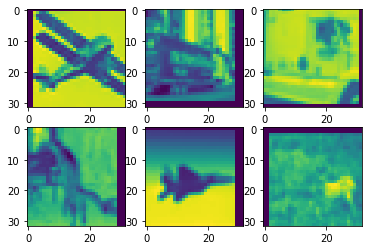

In [3]:
#setting transforms for train and test sets
train_tfs = transforms.Compose([transforms.RandomCrop(32,padding=4),
                                transforms.RandomHorizontalFlip(p=0.7),transforms.ToTensor(),
                                transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,.225])])

test_tfs = transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])])

#loading and preparing data
train_data = datasets.CIFAR10(root=r"C:\Users\Darshan Khandelwal\OneDrive\Desktop\data",download=True,transform=train_tfs,train=True)
trainloader = DataLoader(dataset=train_data,batch_size=128,shuffle=True)
test_data = datasets.CIFAR10(root=r"C:\Users\Darshan Khandelwal\OneDrive\Desktop\data",download=False,transform=test_tfs,train=False)
testloader = DataLoader(dataset=test_data,batch_size=128)

#10 classes of CIFAR10
classes = ['plane','car','bird','cat','deer','dog','frog','horse','ship','truck']

#plotting some examples from the training set
examples = iter(trainloader)
samples,labels = examples.next()
print(samples.shape)
print(labels.shape)
for i in range(6):
    plt.subplot(2,3,i+1)   
    plt.imshow(samples[i][0])
plt.show()

In [0]:
def ResNet32():
  class Basic_Module(nn.Module):
    #Basic Block with identity maps as shortcuts
    def __init__(self,in_channel,out_channel,stride=1):
      super(Basic_Module,self).__init__()
      self.conv1 = nn.Conv2d(in_channel,out_channel,kernel_size=3,stride=stride,padding=1,bias=False)
      self.bn1 = nn.BatchNorm2d(out_channel)
      self.conv2 = nn.Conv2d(out_channel,out_channel,kernel_size=3,padding=1,bias=False)
      self.bn2 = nn.BatchNorm2d(out_channel)
      self.shortcut = nn.Sequential()

      if stride!=1 or in_channel!=out_channel:
        self.shortcut = nn.Sequential(
                          nn.Conv2d(in_channel,out_channel,kernel_size=1,stride=stride,bias=False),
                          nn.BatchNorm2d(out_channel))

    def forward(self,x):
      x_shortcut = x    
      x = torch.celu(self.bn1(self.conv1(x)),alpha=0.075)
      x = self.bn2(self.conv2(x))
      x_shortcut = self.shortcut(x_shortcut)
      #creating a shortcut connection
      x = x + x_shortcut
      x = torch.celu(x,alpha=0.075)
      return x

  class Bottleneck_Module(nn.Module):
    #Bottleneck block with identity map as shortcuts
    def __init__(self,in_channel,out_channel,stride=1):
      super(Bottleneck_Module,self).__init__()
      self.conv1 = nn.Conv2d(in_channel,out_channel,kernel_size=1,padding=0,bias=False)
      self.bn1 = nn.BatchNorm2d(out_channel)
      self.conv2 = nn.Conv2d(out_channel,out_channel,kernel_size=3,padding=1,bias=False)
      self.bn2 = nn.BatchNorm2d(out_channel)
      self.conv3 = nn.Conv2d(out_channel,out_channel,kernel_size=1,padding=0,bias=False,stride=stride)
      self.bn3 = nn.BatchNorm2d(out_channel)
      self.shortcut = nn.Sequential()

      if stride!=1 or in_channel!=out_channel:
        self.shortcut = nn.Sequential(
                          nn.Conv2d(in_channel,out_channel,kernel_size=1,stride=stride,bias=False),
                          nn.BatchNorm2d(out_channel))

    def forward(self,x):
      x_shortcut = x
      x = torch.celu(self.bn1(self.conv1(x)),alpha=0.075)
      x = torch.celu(self.bn2(self.conv2(x)),alpha=0.075)
      x = self.bn3(self.conv3(x))
      x_shortcut = self.shortcut(x_shortcut)
      #creating a shortcut connection
      x = x + x_shortcut
      x = torch.celu(x,alpha=0.075)
      return x

  class ResNet(nn.Module):
    #main resnet model
    def __init__(self,block,filter_map,n,classes=10):
      super(ResNet,self).__init__()
      self.conv1 = nn.Conv2d(3,filter_map[0],kernel_size=3,padding=1,bias=False)
      self.bn1 = nn.BatchNorm2d(filter_map[0])
      self.block1 = self.MakeResnetLayer(block,(filter_map[0],filter_map[0]),n,stride=1)
      self.block2 = self.MakeResnetLayer(block,(filter_map[0],filter_map[1]),n,stride=2)
      self.block3 = self.MakeResnetLayer(block,(filter_map[1],filter_map[2]),n,stride=2)
      self.GloabalAveragePool = nn.AdaptiveAvgPool2d(2)
      self.fc = nn.Linear(2*2*filter_map[2],classes,bias=True)  

    def MakeResnetLayer(self,block,filters,n,stride):
      #defining filters
      in_channel,out_channel = filters
      #layers to be added at given stage
      layer = []
      layer.append(block(in_channel,out_channel,stride))
      for i in range(n-1):
        layer.append(block(out_channel,out_channel))
      #stacking all layers
      SubBlock = nn.Sequential(*layer)
      return SubBlock

    def forward(self,x):
      #initial layers
      x = torch.relu(self.bn1(self.conv1(x)))
      #stage1
      x = self.block1(x)
      #stage2
      x = self.block2(x)
      #stage3
      x = self.block3(x)
      #final layers
      x = self.GloabalAveragePool(x)
      x = x.view(-1,2*2*64)
      x = self.fc(x)
      return x
   
  #creating an object of resnet model and pushing it to device(CPU/GPU)
  model1 = ResNet(Basic_Module,[16,32,64],5).to(device)
  model2 = ResNet(Bottleneck_Module,[16,32,64],5).to(device)
  return model1,model2

#defining models
ModelBasic,ModelBottleneck = ResNet32()

In [0]:
# Creating STORM optimizer class as per algorithm in the paper https://arxiv.org/abs/1905.10018

class StormOptimizer(Optimizer):    
    # Storing the parameters required in defaults dictionary
    # lr-->learning rate
    # c-->parameter to be swept over logarithmically spaced grid as per paper
    # w and k to be set as 0.1 as per paper
    # momentum-->dictionary storing model params as keys and their momentum term as values at each iteration(denoted by 'd' in paper)
    # gradient--> dictionary storing model params as keys and their gradients till now in a list as values(denoted by '∇f(x,ε)' in paper)
    # sqrgradnorm-->dictionary storing model params as keys and their sum of norm ofgradients till now as values(denoted by '∑G^2' in paper)

    def __init__(self,params,lr=0.1,c=100,momentum={},gradient={},sqrgradnorm={}):
        defaults = dict(lr=lr,c=c,momentum=momentum,sqrgradnorm=sqrgradnorm,gradient=gradient)
        super(StormOptimizer,self).__init__(params,defaults)

    # Returns the state of the optimizer as a dictionary containing state and param_groups as keys
    def __setstate__(self,state):
        super(StormOptimizer,self).__setstate__(state)

    # Performs a single optimization step for parameter updates
    def step(self,closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        # param_groups-->a dict containing all parameter groups
        for group in self.param_groups:
           # Retrieving from defaults dictionary
           learn_rate = group['lr']
           factor = group['c']
           momentum = group['momentum']
           gradient = group['gradient']
           sqrgradnorm = group['sqrgradnorm']

           # Update step for each parameter present in param_groups
           for p in group['params']:
                # Calculating gradient('∇f(x,ε)' in paper)
                if p.grad is None:
                    continue
                dp = p.grad.data

                # Storing all gradients in a list
                if p in gradient:
                    gradient[p].append(dp)
                else:
                    gradient.update({p:[dp]})

                # Calculating and storing ∑G^2in sqrgradnorm
                if p in sqrgradnorm:
                    sqrgradnorm[p] = sqrgradnorm[p] + torch.pow(torch.norm(dp),2)
                else:
                    sqrgradnorm.update({p:torch.pow(torch.norm(dp),2)})

                # Updating learning rate('η' in paper)
                power = 1.0/3.0
                scaling = torch.pow((0.1 + sqrgradnorm[p]),power)
                learn_rate = learn_rate/(float)(scaling)

                # Calculating 'a' mentioned as a=cη^2 in paper(denoted 'c' as factor here)
                a = min(factor*learn_rate**2.0,1.0)

                # Calculating and storing the momentum term(d'=∇f(x',ε')+(1-a')(d-∇f(x,ε')))
                if p in momentum:
                    momentum[p] = gradient[p][-1] + (1-a)*(momentum[p]-gradient[p][-2])
                else:
                    momentum.update({p:dp})

                # Updation of model parameter p                
                p.data = p.data-learn_rate*momentum[p]
                learn_rate = group['lr']
        
        return loss


In [0]:
#hyperparameters and dictionaries(for STORM optimizer)
num_epochs=80
learn_rate=0.1
batch_size=128
c=100
momentum={}
gradient={}
sqrgradnorm={}

#defining the loss criteria to be used
criterion = nn.CrossEntropyLoss()

#defining the optimizers and schedulers
optimizer1 = optim.Adam(ModelBottleneck.parameters(),lr=learn_rate)
scheduler1 = MultiStepLR(optimizer1,milestones=[50,70],gamma=0.5)
optimizer2 = optim.Adagrad(ModelBottleneck.parameters(),lr=learn_rate)
scheduler2 = MultiStepLR(optimizer2,milestones=[50,70],gamma=0.7)
optimizer3 = StormOptimizer(ModelBottleneck.parameters(),learn_rate,c,momentum,gradient,sqrgradnorm)
scheduler3 = None   #learning rate is already modified inside optimizer so there is no need of lr_scheduler

In [12]:
print("ADAM OPTIMIZER::\n")
tr_loss1,tr_acc1,test_acc1 = build_model(trainloader,testloader,device,ModelBottleneck,criterion,optimizer1,scheduler1,num_epochs,classes,batch_size)

ADAM OPTIMIZER::

epoch: 10 / 80  loss:0.0112
epoch: 20 / 80  loss:0.0070
epoch: 30 / 80  loss:0.0050
epoch: 40 / 80  loss:0.0040
epoch: 50 / 80  loss:0.0033
epoch: 60 / 80  loss:0.0028
epoch: 70 / 80  loss:0.0026
epoch: 80 / 80  loss:0.0024


Overall accuracy of system: 71.44%
Accuracy of plane = 62.30%
Accuracy of car = 65.00%
Accuracy of bird = 77.60%
Accuracy of cat = 75.40%
Accuracy of deer = 88.50%
Accuracy of dog = 55.10%
Accuracy of frog = 85.70%
Accuracy of horse = 70.60%
Accuracy of ship = 79.40%
Accuracy of truck = 54.80%


In [8]:
print("ADAGRAD OPTIMIZER::\n")
tr_loss2,tr_acc2,test_acc2 = build_model(trainloader,testloader,device,ModelBottleneck,criterion,optimizer2,scheduler2,num_epochs,classes,batch_size)

ADAGRAD OPTIMIZER::

epoch: 10 / 80  loss:0.0058
epoch: 20 / 80  loss:0.0037
epoch: 30 / 80  loss:0.0028
epoch: 40 / 80  loss:0.0023
epoch: 50 / 80  loss:0.0019
epoch: 60 / 80  loss:0.0016
epoch: 70 / 80  loss:0.0014
epoch: 80 / 80  loss:0.0012


Overall accuracy of system: 68.22%
Accuracy of plane = 70.50%
Accuracy of car = 71.00%
Accuracy of bird = 65.90%
Accuracy of cat = 76.30%
Accuracy of deer = 85.10%
Accuracy of dog = 37.20%
Accuracy of frog = 78.70%
Accuracy of horse = 55.40%
Accuracy of ship = 78.70%
Accuracy of truck = 63.40%


In [9]:
print("STORM OPTIMIZER::\n")
tr_loss3,tr_acc3,test_acc3 = build_model(trainloader,testloader,device,ModelBottleneck,criterion,optimizer3,scheduler3,num_epochs,classes,batch_size)

STORM OPTIMIZER::

epoch: 10 / 80  loss:0.0009
epoch: 20 / 80  loss:0.0009
epoch: 30 / 80  loss:0.0009
epoch: 40 / 80  loss:0.0008
epoch: 50 / 80  loss:0.0008
epoch: 60 / 80  loss:0.0008
epoch: 70 / 80  loss:0.0008
epoch: 80 / 80  loss:0.0008


Overall accuracy of system: 69.71%
Accuracy of plane = 67.80%
Accuracy of car = 69.50%
Accuracy of bird = 79.60%
Accuracy of cat = 63.30%
Accuracy of deer = 85.00%
Accuracy of dog = 53.00%
Accuracy of frog = 76.20%
Accuracy of horse = 56.60%
Accuracy of ship = 80.80%
Accuracy of truck = 65.30%


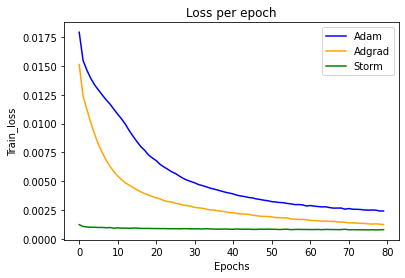

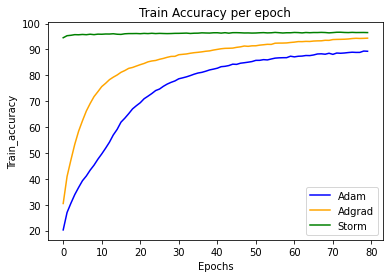

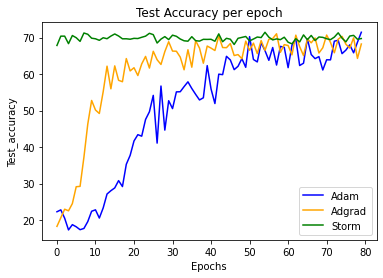

In [13]:
#plotting train_loss per epoch 
plt.plot(tr_loss1,color="b",label="Adam")
plt.plot(tr_loss2,color="orange",label="Adgrad")
plt.plot(tr_loss3,color="g",label="Storm")
plt.xlabel("Epochs")
plt.ylabel("Train_loss")
plt.title("Loss per epoch")
plt.legend()
plt.show()

#plotting train_accuracy per epoch 
plt.plot(tr_acc1,color="b",label="Adam")
plt.plot(tr_acc2,color="orange",label="Adgrad")
plt.plot(tr_acc3,color="g",label="Storm")
plt.xlabel("Epochs")
plt.ylabel("Train_accuracy")
plt.title("Train Accuracy per epoch")
plt.legend()
plt.show()

#plotting test_accuracy per epoch 
plt.plot(test_acc1,color="b",label="Adam")
plt.plot(test_acc2,color="orange",label="Adgrad")
plt.plot(test_acc3,color="g",label="Storm")
plt.xlabel("Epochs")
plt.ylabel("Test_accuracy")
plt.title("Test Accuracy per epoch")
plt.legend()
plt.show()